In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Execute if necessary
# %%capture
# !pip install pandas
# !pip install pytorchtools

In [ ]:
import zipfile
import random
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn.functional as F

### Plotting - Helpers

In [ ]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    
    
def plot_accuracy(train_acc, valid_acc):

    num_epochs = len(train_acc)

    plt.plot(np.arange(1, num_epochs+1), 
             train_acc, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
                
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            
            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()
    
    
def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

    with torch.no_grad():

        ##########################
        ### RANDOM SAMPLE
        ##########################    

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        color_channels = new_images.shape[1]
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        ##########################
        ### VISUALIZATION
        ##########################

        image_width = 28

        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
        decoded_images = new_images[:num_images]

        for ax, img in zip(axes, decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax.imshow(curr_img)
            else:
                ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 
                
                

### Utils

In [ ]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Evaluate - Helpers

In [ ]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Práctica 7: Redes Neuronales (Autoencoders Variacionales)

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

__Para esta práctica se deben usar bibliotecas__. Se recomienda el uso de:

- scikit-learn (https://scikit-learn.org/stable/)
- plotly express (https://plotly.com/python/plotly-express/)
- torch (https://pytorch.org/).

## Asignación 1

Seleccione algun dataset de su preferencia para el cual sea viable entrenar un modelo generativo (VAE), preferentemente de imagenes (pequeñas). Particione sus datos para poder realizar selección de modelos (__conjunto de validación__).

In [ ]:
#with zipfile.ZipFile('/content/drive/MyDrive/ModeladoPredicitivo/all-dogs.zip','r') as zip_file:
#  zip_file.extractall('/content/drive/MyDrive/ModeladoPredicitivo/all-dogs/dogs/')

In [ ]:
root = '/content/drive/MyDrive/ModeladoPredicitivo/all-dogs/dogs/all-dogs'
img_list = os.listdir(root)
print(len(img_list))

20579


In [ ]:
root = '/content/drive/MyDrive/ModeladoPredicitivo/all-dogs/dogs/'
dataset = datasets.ImageFolder(root, transform=transforms.Compose([
                          transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(1., 1.)),
                          transforms.RandomHorizontalFlip(),
                          transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                          transforms.ToTensor(),
                      ]))

In [ ]:
train_size = int(len(img_list) * 0.8)
test_size = len(img_list) - train_size
train_set, test_set = data.random_split(dataset, [train_size, test_size])
print(f"train set: {len(train_set)} \ntest_set: {len(test_set)}")

train set: 16463 
test_set: 4116


In [ ]:
print(type(train_set[0][0]))

<class 'torch.Tensor'>


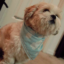

In [ ]:
tensor = train_set[0][0]
transform = transforms.ToPILImage()
img = transform(tensor)
img.show()

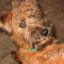

In [ ]:
tensor = test_set[0][0]
transform = transforms.ToPILImage()
img = transform(tensor)
img.show()

## Asignación 2

Realice un análisis exploratorio de datos y el preprocesamiento necesario para el dataset seleccionado.

## Asignación 3

Ajuste un Autoencoder Variacional (VAE) que permita realizar la generación de nuevos datos. Debe generar las curvas de entrenamiento (y graficarlas) e implementar el método de early stopping para seleccionar el modelo más adecuado.

In [ ]:
#Setings
DEVICE = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running in : {DEVICE}")

#HyperParams
RANDOM_SEED = 123
LEARNING_RATE = 3e-4
BATCH_SIZE = 256
EPOCHS = 50

Running in : cuda


In [ ]:
set_deterministic #Forces CUDA to use deterministic algorithms only
set_all_seeds(RANDOM_SEED)

In [ ]:
train_loader = DataLoader(dataset=train_set,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=True)

valid_loader = DataLoader(dataset=test_set,
                              batch_size=BATCH_SIZE,
                              num_workers=0,
                              shuffle=False)

In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break


Training Set:



In [ ]:
###MODEL
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)#The new dimension has to be compatible with the former


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :64, :64] #Trim the output layer to the size of the image


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(#Sequential container, modules wil be added to it in the order they are passed in 
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32), #Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift 
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25), #During training drop nodes and scale activations by (1-p)  p = drop probability
                # (256,32,32,32)
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                # (256,64,16,16)
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                # (256,64,8,8)
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                # (256, 64, 4, 4)
                nn.Flatten()#(256,1024)
        )    
        
        self.z_mean = torch.nn.Linear(1024, 200)
        self.z_log_var = torch.nn.Linear(1024, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 1024),
                Reshape(-1, 64, 4, 4),
                # (256,64,4,4)
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #(256,64,9,9)
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #(256,64,19,19)
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #(256,32,37,37)
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #(256,3,73,73)
                Trim(),  # (256, 3, 64, 64)
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    #Help us make the monte carlo estimate of the marginal likelihood differentiable by writing z in terms of epsilon   
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        print(z_mean, z_log_var)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [ ]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

#instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
#Training
def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, valid_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'test_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}



    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):
            print(features.shape)
            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model.forward(features)
            
            # total loss = reconstruction loss + KL divergence
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

                #validation
                validation_loss = compute_epoch_loss_autoencoder(
                    model, valid_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, validation_loss))
                log_dict['test_combined_per_epoch'].append(validation_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        if early_stopper.early_stop(validation_loss):             
          break
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [ ]:
#Training
log_dict = train_vae_v1(num_epochs=EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        valid_loader = valid_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='/content/drive/MyDrive/ModeladoPredicitivo/vae_doggos.pt')

In [ ]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

## Asignación 4

Realice la generación de nuevos datos utilizando su modelo. Debe generar evidencia sobre el correcto funcionamiento de su modelo.

In [ ]:
#train set
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')         

In [ ]:
#test set
plot_generated_images(data_loader=test_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')         

In [ ]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()